# Descripción del conjunto de datos

Debe haber una columna de predicción por imagen, y las etiquetas se representan como números enteros que corresponden cada uno a una parte del cuerpo contenida en el conjunto de datos:

* Abdomen = 0
* Tobillo = 1
* Columna cervical = 2
* Tórax = 3
* Clavículas = 4
* Codo = 5
* Pies = 6
* Dedos = 7
* Antebrazo = 8
* Mano = 9
* Cadera = 10
* Rodilla = 11
* Pierna = 12
* Columna lumbar = 13
* Otros = 14
* Pelvis = 15
* Hombro = 16
* Senos paranasales = 17
* Cráneo = 18
* Muslo = 19
* Columna torácica = 20
* Muñeca = 21

*Nota*: Otros indica si la muestra contiene imágenes no radiográficas que a veces se colocan erróneamente en el sistema PACS como radiografías (por ejemplo, esofagograma, densitometría).

### Archivos

* train.csv - el conjunto de entrenamiento. Contiene el SOPInstanceUID y la información del objetivo.
* sample_submission.csv - un archivo de presentación de muestras en el formato correcto. Contiene SOPInstanceUID para el conjunto de test.

### Columnas

* SOPInstanceUID- Cada SOPInstanceUID corresponde a una imagen única.
* Target - La etiqueta asignada a cada muestra.

# SetUp

In [ ]:
!pip install pydicom
!pip install pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import shutil
import re
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import warnings
import random
from zipfile import ZipFile
import re




warnings.filterwarnings("ignore", category=UserWarning, module="pydicom")


In [ ]:
# Rutas a los directorios
train_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train'
test_dir = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/test'
train_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/train.csv'
sample_submission_csv = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/sample_submission.csv'

# Cargar los datos de entrenamiento
train_df = pd.read_csv(train_csv)

# Visualizar algunas filas del DataFrame
train_df.head(10)


SOPInstanceUID  Target
0  1.2.826.0.1.3680043.8.498.10062189329714053601...      14
1  1.2.826.0.1.3680043.8.498.53411283183733547704...       3
2  1.2.826.0.1.3680043.8.498.12955484645689261949...       3
3  1.2.826.0.1.3680043.8.498.10408703585974384892...       3
4  1.2.826.0.1.3680043.8.498.30255106562321206269...       9
5  1.2.826.0.1.3680043.8.498.80404681981834387091...       0
6  1.2.826.0.1.3680043.8.498.16743022096024694044...       2
7  1.2.826.0.1.3680043.8.498.33303514480609398517...       2
8  1.2.826.0.1.3680043.8.498.15144815417970827102...      13
9  1.2.826.0.1.3680043.8.498.19878644487806502082...       3

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1278 non-null   object
 1   Target          1278 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


#Exploracion de imagenes

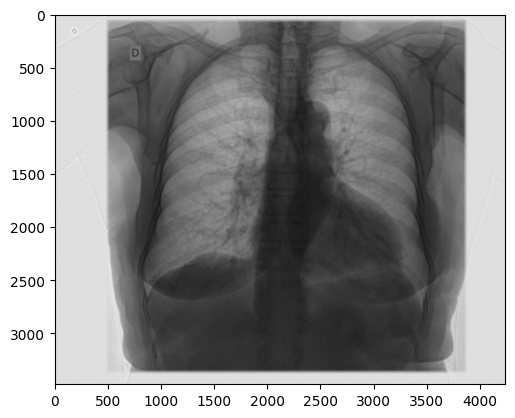

In [ ]:
def show_dicom_image_single(file_path):
    dicom = pydicom.dcmread(file_path)
    plt.imshow(dicom.pixel_array, cmap='gray')
    plt.show()

#  imagen de ejemplo
example_image_path = os.path.join(train_dir, train_df.iloc[2]['SOPInstanceUID'] + '.dcm')
show_dicom_image_single(example_image_path)


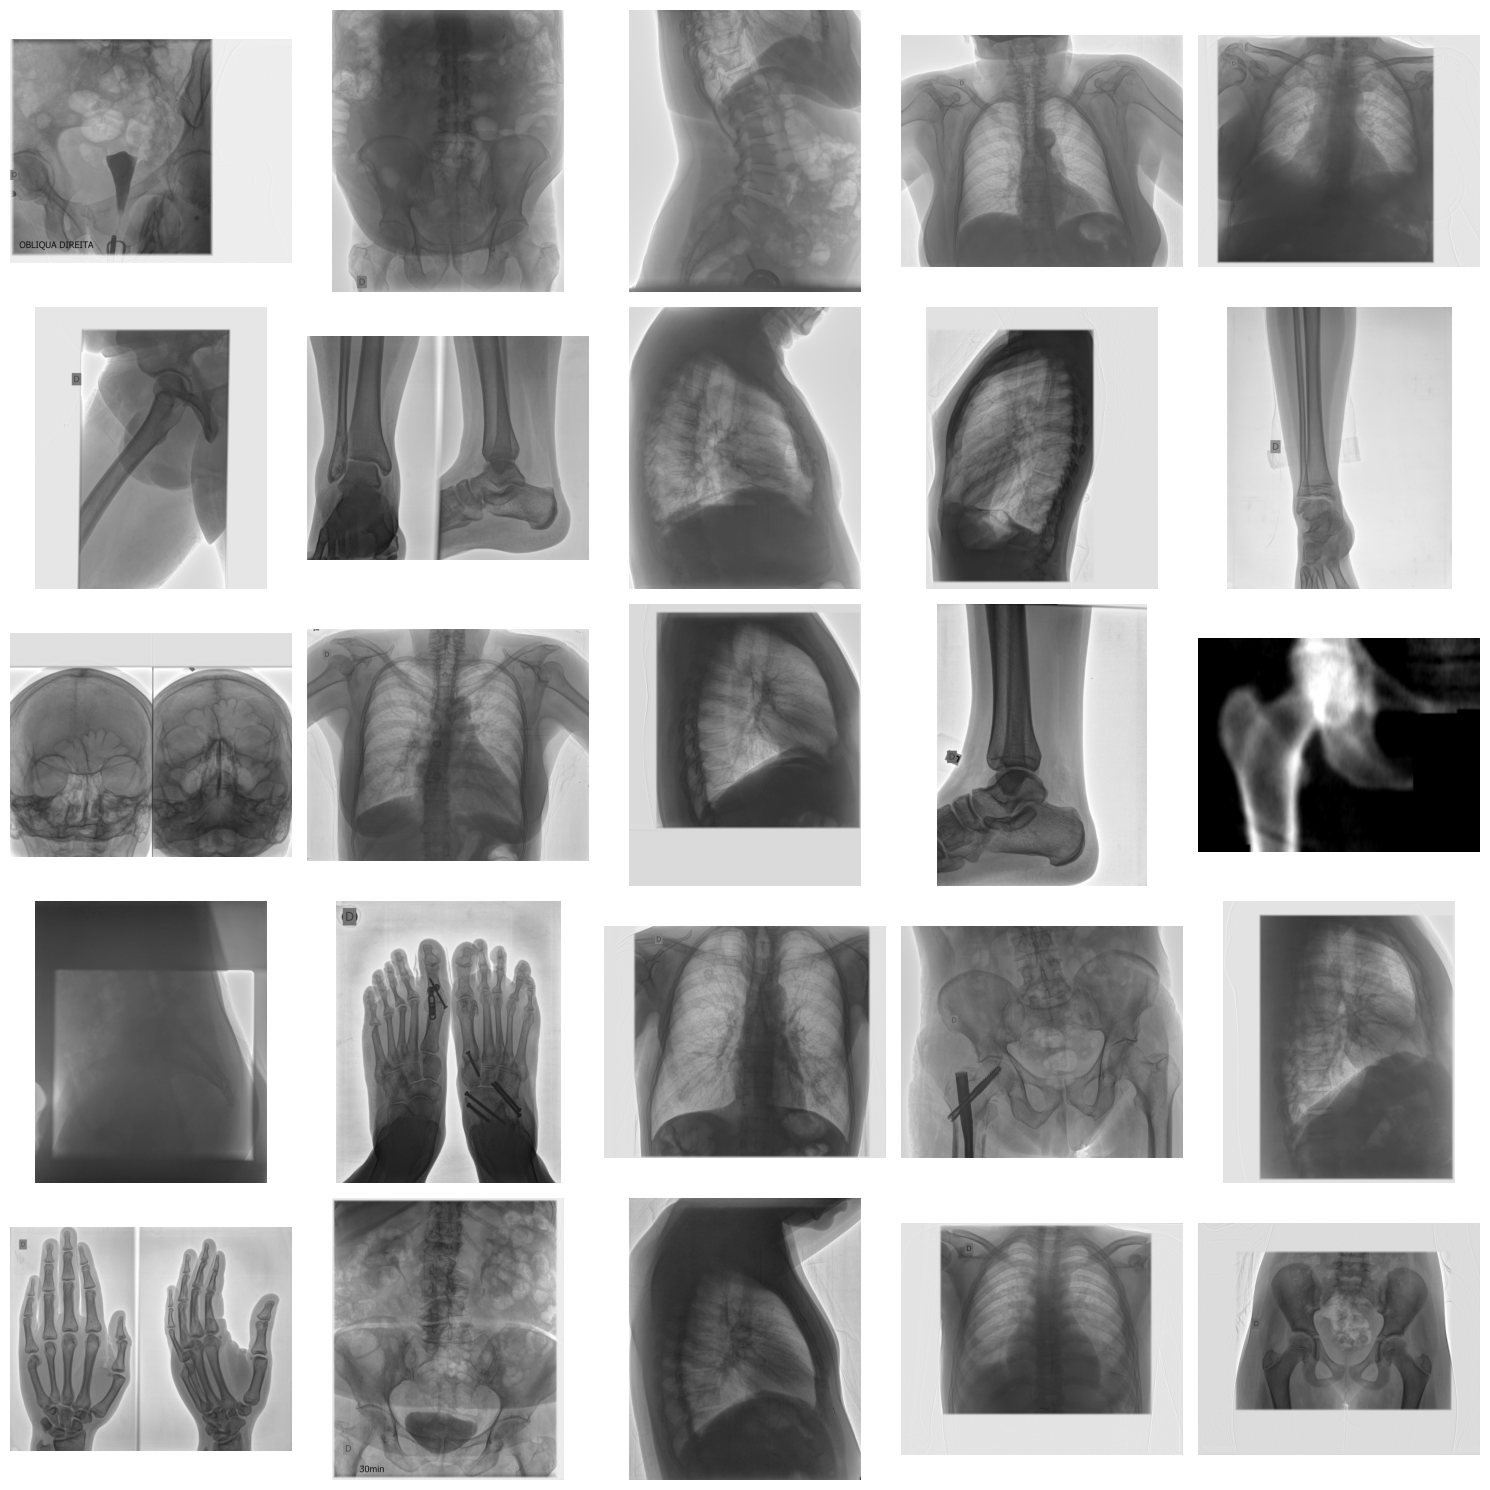

In [ ]:
def show_dicom_image_multi(file_path, ax):
    dicom = pydicom.dcmread(file_path)
    ax.imshow(dicom.pixel_array, cmap='gray')
    ax.axis('off')  # Desactivar ejes

# Seleccionar 25 imágenes al azar
random_indices = random.sample(range(len(train_df)), 25)
random_image_paths = [os.path.join(train_dir, train_df.iloc[i]['SOPInstanceUID'] + '.dcm') for i in random_indices]

# Crear una figura y ejes para una matriz de 5x5
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Mostrar cada imagen en su correspondiente subgráfico
for ax, image_path in zip(axes.flat, random_image_paths):
    show_dicom_image_multi(image_path, ax)

# Ajustar el espacio entre subgráficos
plt.tight_layout()
plt.show()


# Procesamiento de imagenes

Ajuste de dimensiones y parametros. Aca se pueden agregar otras transformaciones y filtros para mejorar las siluetas. Tambien aplicar transformaciones que vimos en clase para reducir la dimensionalidad. Revisar

In [ ]:
#Numero maximo de imagenes para entrenar el modelo
max = len(train_df)

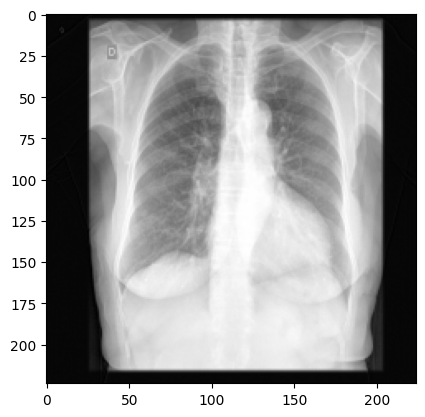

Información de la imagen preprocesada:
Dimensiones de la imagen: (224, 224, 3)
Canales de la imagen: 3
Tipo de datos de la imagen: uint8
Información del archivo DICOM:
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 244
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.12955484645689261949928855045724356601
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.10
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.10'
(0002, 0016) Source Application Entity Title     AE: 'gdcmconv'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMAR

In [ ]:

def preprocess_image(dicom):
    """
    Preprocess a DICOM image and return a numpy array.
    """
    img = dicom.pixel_array
    # Clip the image intensities to the 1st and 99th percentiles
    p01 = np.percentile(img.ravel(), 1)
    p99 = np.percentile(img.ravel(), 99)
    img[img > p99] = p99
    img[img < p01] = p01
    # Invert the image if it is MONOCHROME1
    if dicom.PhotometricInterpretation == 'MONOCHROME1':
        img = np.invert(img)
    # Normalize the image to the range 0-255
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = cv2.convertScaleAbs(img)
    return img

def convert_to_rgb(img):
    """
    Convert a single-channel or two-channel image to RGB.
    """
    if len(img.shape) == 2:  # Grayscale
        img = np.stack([img] * 3, axis=-1)
    elif img.shape[-1] == 2:  # Two channels
        img = np.concatenate([img, img[:, :, :1]], axis=-1)  # Duplicate one channel
    return img



def preprocess_and_load_image(file_path, target_size=(224, 224)):
    """
    Combined function to preprocess and load a DICOM image, then resize it to the target size.
    """
    dicom = pydicom.dcmread(file_path)
    img = preprocess_image(dicom)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    img = convert_to_rgb(img)
    return img


# Preprocesar una imagen de ejemplo
preprocessed_img = preprocess_and_load_image(example_image_path)

# Mostrar la imagen preprocesada
plt.imshow(preprocessed_img, cmap='gray')
plt.show()

# Imprimir información sobre la imagen preprocesada
print("Información de la imagen preprocesada:")
print("Dimensiones de la imagen:", preprocessed_img.shape)
print("Canales de la imagen:", preprocessed_img.shape[2])
print("Tipo de datos de la imagen:", preprocessed_img.dtype)
print("Información del archivo DICOM:")
print(pydicom.dcmread(example_image_path))


Procesamiento batch de todas las imagenes y division en test y train

Cargar, procesar y guardar imagenes en zip

In [ ]:
"""
def preprocess_images(num_images, train_df, train_dir):
    X = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Cargar y preprocesar las imágenes de entrenamiento especificadas
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Preprocesando imágenes"):
        if idx >= num_images:
            break
        img_path = os.path.join(train_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_and_load_image(img_path)  # Utiliza tu función de preprocesamiento de imágenes aquí)
        X.append(img)


    X = np.array(X)
    return X


def save_images_to_zip(X, zip_path):
    with ZipFile(zip_path, 'w') as zipf:
        for idx, img in tqdm(enumerate(X), total=len(X), desc="Guardando imágenes"):
            img_filename = f'image_{idx}.png'

            # Convertir la imagen a formato adecuado para guardar con PIL
            pil_img = Image.fromarray(img)

            with BytesIO() as buffer:
                pil_img.save(buffer, format="PNG", quality=100)  # Guardar con la máxima calidad en PNG
                buffer.seek(0)
                zipf.writestr(img_filename, buffer.read())


# Especificar la cantidad de imágenes a procesar
num_images_to_process = max

# Preprocesar las imágenes
X = preprocess_images(num_images_to_process, train_df, train_dir)

# Especificar el directorio de guardado y el nombre del archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_6.zip'

# Guardar las imágenes procesadas en un archivo zip
save_images_to_zip(X, zip_path)

"""

Extraer imagenes

In [ ]:
def extract_and_load_images(zip_path):
    # Crear un directorio temporal para extraer las imágenes
    extract_dir = './temp_extracted_images'
    os.makedirs(extract_dir, exist_ok=True)

    # Extraer los archivos del zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Obtener la lista de archivos extraídos y ordenarlos alfabéticamente
    extracted_files = os.listdir(extract_dir)
    extracted_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))  # Ordenar los archivos según el número en el nombre

    # Lista para almacenar las imágenes cargadas
    X = []

    # Cargar las imágenes seleccionadas
    for filename in extracted_files:
        img_path = os.path.join(extract_dir, filename)
        img = plt.imread(img_path)
        X.append(img)

    # Convertir la lista de imágenes a un array de numpy
    X = np.array(X)

    # Limpiar el directorio temporal
    for file in extracted_files:
        os.remove(os.path.join(extract_dir, file))
    os.rmdir(extract_dir)

    print("Proceso de extracción y carga de imágenes completado correctamente.")
    print(f"Total de imágenes descomprimidas: {len(extracted_files)}")

    return X

# Especificar la ruta del archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_5.zip'

# Extraer y cargar las imágenes en la variable X
X = extract_and_load_images(zip_path)


Proceso de extracción y carga de imágenes completado correctamente.
Total de imágenes descomprimidas: 1278


encode labels y split

In [ ]:
def encode_labels(train_df, num_images):
    y = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Obtener las etiquetas de las imágenes
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Codificando etiquetas"):
        if idx >= num_images:
            break
        y.append(row['Target'])

    return y

def encode_labels_2(train_df, num_images):
    y = []

    # Obtener la cantidad total de imágenes
    total_images = min(num_images, len(train_df))

    # Obtener las etiquetas de las imágenes
    for idx, row in tqdm(train_df.iterrows(), total=total_images, desc="Codificando etiquetas"):
        if idx >= num_images:
            break
        y.append(row['Target'])

    # Convertir las listas de etiquetas en matrices numpy
    y = np.array(y)

    # Codificación de las etiquetas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return y_encoded, le

def split_train_val_sets(X, y, test_size=0.2, random_state=42):
    # Dividir en conjuntos de entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val

# Especificar la cantidad de imágenes a procesar y el tamaño de imagen deseado
num_images_to_process = max # Usar todas las imágenes disponibles

# Codificar las etiquetas
y, le = encode_labels_2(train_df, num_images_to_process)

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = split_train_val_sets(X, y)




Codificando etiquetas: 100%|██████████| 1278/1278 [00:00<00:00, 19761.99it/s]


Visualizacion de imagenes extraidas y targets

In [ ]:
import matplotlib.pyplot as plt

# Determinar el número máximo de imágenes a mostrar
num_images_to_show = min(25, len(X_train))

# Determinar el número de filas y columnas para la cuadrícula
num_rows = min(5, (num_images_to_show + 4) // 5)  # Asegura al menos una fila
num_cols = min(5, num_images_to_show)  # Asegura al menos una columna

# Configurar la cuadrícula para la visualización
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

# Iterar sobre las imágenes a mostrar
for i in range(num_images_to_show):
    row = i // num_cols
    col = i % num_cols

    # Obtener la imagen y la etiqueta correspondiente
    img = X_train[i]
    label = y_train[i]

    # Mostrar la imagen
    if num_rows == 1:  # Si solo hay una fila, axs será un arreglo unidimensional
        axs[col].imshow(img)
        axs[col].axis('off')
        axs[col].set_title(f'Image {i + 1}\nLabel: {label}')
    else:  # Si hay más de una fila, axs será una matriz bidimensional
        axs[row, col].imshow(img)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Image {i + 1}\nLabel: {label}')

# Ocultar los ejes de los subplots no utilizados
for j in range(num_images_to_show, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    if num_rows == 1:  # Si solo hay una fila, axs será un arreglo unidimensional
        axs[col].axis('off')
    else:  # Si hay más de una fila, axs será una matriz bidimensional
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Modelo

### Implementacion con Fast AI

ResNet, que significa "Redes Residuales", es una arquitectura de red neuronal convolucional (CNN) desarrollada por Microsoft Research en 2015. ResNet introdujo el concepto de "skip connections" o "conexiones residuales", que permiten que las redes neuronales profundas se vuelvan aún más profundas sin sufrir el problema de degradación de la precisión.


'Un "epoch" en el contexto del entrenamiento de modelos de aprendizaje automático se refiere a una pasada completa de todos los ejemplos de entrenamiento a través del modelo. En otras palabras, durante un epoch, el modelo ve todos los ejemplos de entrenamiento una vez y ajusta sus pesos en consecuencia para mejorar su desempeño.

Durante el entrenamiento de un modelo, los datos de entrenamiento se dividen en lotes de un tamaño específico (por ejemplo, 32, 64, etc.). Durante cada epoch, el modelo pasa por todos los lotes de entrenamiento, calcula la pérdida y ajusta sus pesos utilizando un algoritmo de optimización, como el descenso del gradiente estocástico (SGD) o Adam. Después de pasar por todos los lotes de entrenamiento, se completa un epoch y el modelo pasa al siguiente epoch.

El número de epochs que se especifica en el entrenamiento del modelo (epochs=10 en tu caso) indica cuántas veces se repetirá este proceso completo de pasar por todos los ejemplos de entrenamiento. A menudo, se requieren múltiples epochs para que el modelo aprenda patrones complejos en los datos y mejore su rendimiento. Sin embargo, es importante evitar el sobreajuste al entrenar demasiado tiempo, por lo que es común utilizar técnicas como el early stopping para detener el entrenamiento una vez que el rendimiento en el conjunto de validación deja de mejorar.'

Extracion de imagenes te train en zip, y preprocesaado con data augmentation

Proceso de extracción y carga de imágenes completado correctamente.
Total de imágenes descomprimidas: 1278


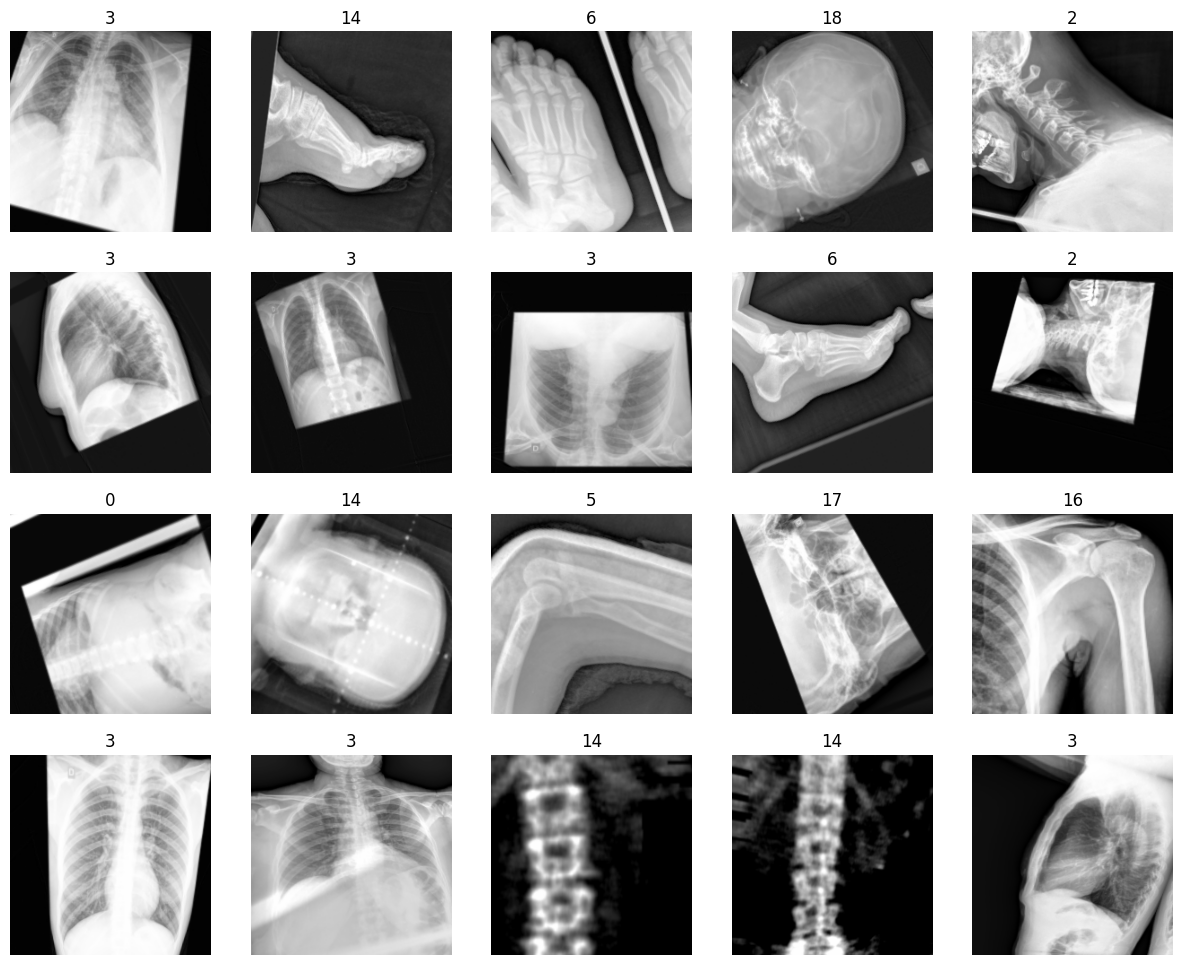

In [ ]:
import os
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *


def extract_and_load_images(zip_path):
    # Crear un directorio temporal para extraer las imágenes
    extract_dir = './temp_extracted_images'
    os.makedirs(extract_dir, exist_ok=True)

    # Extraer los archivos del zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Obtener la lista de archivos extraídos y ordenarlos alfabéticamente
    extracted_files = os.listdir(extract_dir)
    extracted_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))  # Ordenar los archivos según el número en el nombre

    # Lista para almacenar las imágenes cargadas
    X = []

    # Cargar las imágenes seleccionadas
    for filename in extracted_files:
        img_path = os.path.join(extract_dir, filename)
        img = plt.imread(img_path)
        # Convertir la imagen a uint8
        img = (img * 255).astype(np.uint8)  # Asegurarse de que la imagen esté en el rango correcto y convertir a uint8
        X.append(img)

    # Convertir la lista de imágenes a un array de numpy
    X = np.array(X)

    # Limpiar el directorio temporal
    for file in extracted_files:
        os.remove(os.path.join(extract_dir, file))
    os.rmdir(extract_dir)

    print("Proceso de extracción y carga de imágenes completado correctamente.")
    print(f"Total de imágenes descomprimidas: {len(extracted_files)}")

    return X


# Define la función get_x fuera del alcance local
def get_x(X):
    def _inner(idx):
        return PILImage.create(X[idx])
    return _inner



def create_dataloaders(X, y):
    # Definir la función get_y
    def get_y(idx):
        return y[idx]

    # Crear un DataBlock para FastAI
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=get_x(X),  # Llamar a la función get_x con X
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(224),
        batch_tfms=aug_transforms(
            size=224,
            flip_vert=True,
            max_warp=0.2,
            max_rotate=30,
            max_zoom=1.5,
            max_lighting=0.4,
            xtra_tfms=[RandomResizedCrop(size=(224, 224), min_scale=0.6, max_scale=1.4)]
        )
    )

    # Crear un DataLoader
    dls = dblock.dataloaders(range(len(X)), bs=32)

    return dls


# Especificar la ruta del archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_train_5.zip'

# Extraer y cargar las imágenes en la variable X
X = extract_and_load_images(zip_path)

# Crear los DataLoaders
dls = create_dataloaders(X, y)

# Visualizar algunas imágenes aumentadas junto con sus etiquetas
dls.show_batch(max_n=20)



Entrenamiento de Resnet 50

Busqueda del learning rate optimo

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Learning rate sugerido: 0.001737800776027143


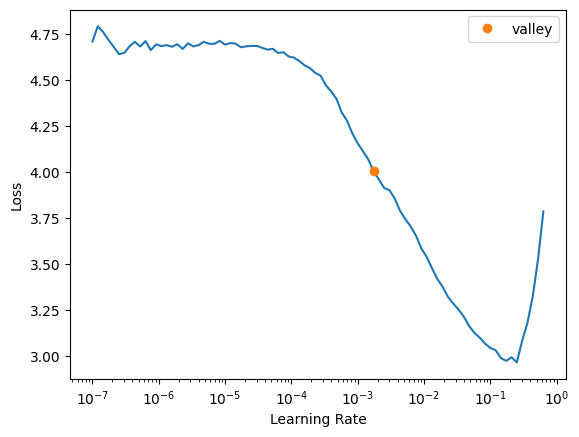

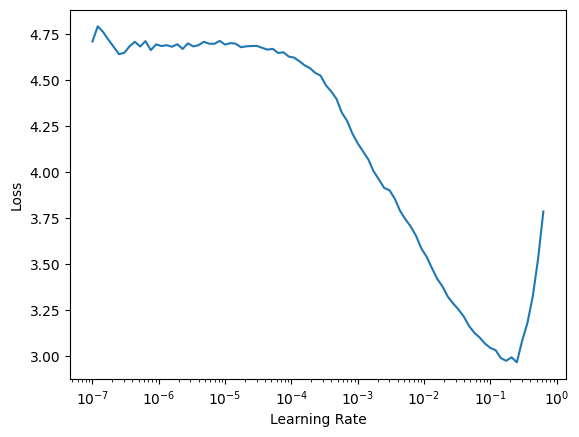

In [ ]:
# Construir el modelo
learn = vision_learner(dls, resnet50, metrics=accuracy)

# Encontrar el learning rate óptimo con el LR Finder
lr_finder = learn.lr_find()

# Imprimir el gráfico del LR Finder
learn.recorder.plot_lr_find()

# Obtener el learning rate sugerido
lr_suggested = lr_finder.valley

# Imprimir el learning rate sugerido
print(f'Learning rate sugerido: {lr_suggested}')

Entrenamiento del Modelo

In [ ]:
# Descongelar todas las capas
learn.unfreeze()

# Ajustar el modelo nuevamente con un learning rate menor para las capas superiores
learn.fit_one_cycle(5, lr_max=slice(lr_suggested/1000, lr_suggested))

# Implementar early stopping
early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

# Entrenar el modelo utilizando el learning rate sugerido
learn.fine_tune(epochs=60, base_lr=lr_suggested, freeze_epochs=3, cbs=[early_stopping_cb])

# Obtener la precisión general y la pérdida
accuracy = learn.validate()[1]
loss = learn.validate()[0]

# Imprimir la precisión general y la pérdida
print(f'Precisión General: {accuracy}')
print(f'Pérdida: {loss}')

# Guardar el modelo entrenado
save_model_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/models/'
learn.save(os.path.join(save_model_path, 'best_model_5'))

No improvement since epoch 13: early stopping


Precisión General: 0.9176470637321472
Pérdida: 0.3700648248195648


Path('/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/models/best_model_5.pth')

Visualizacion de Imagenes y targets ENTRENAMIENTO

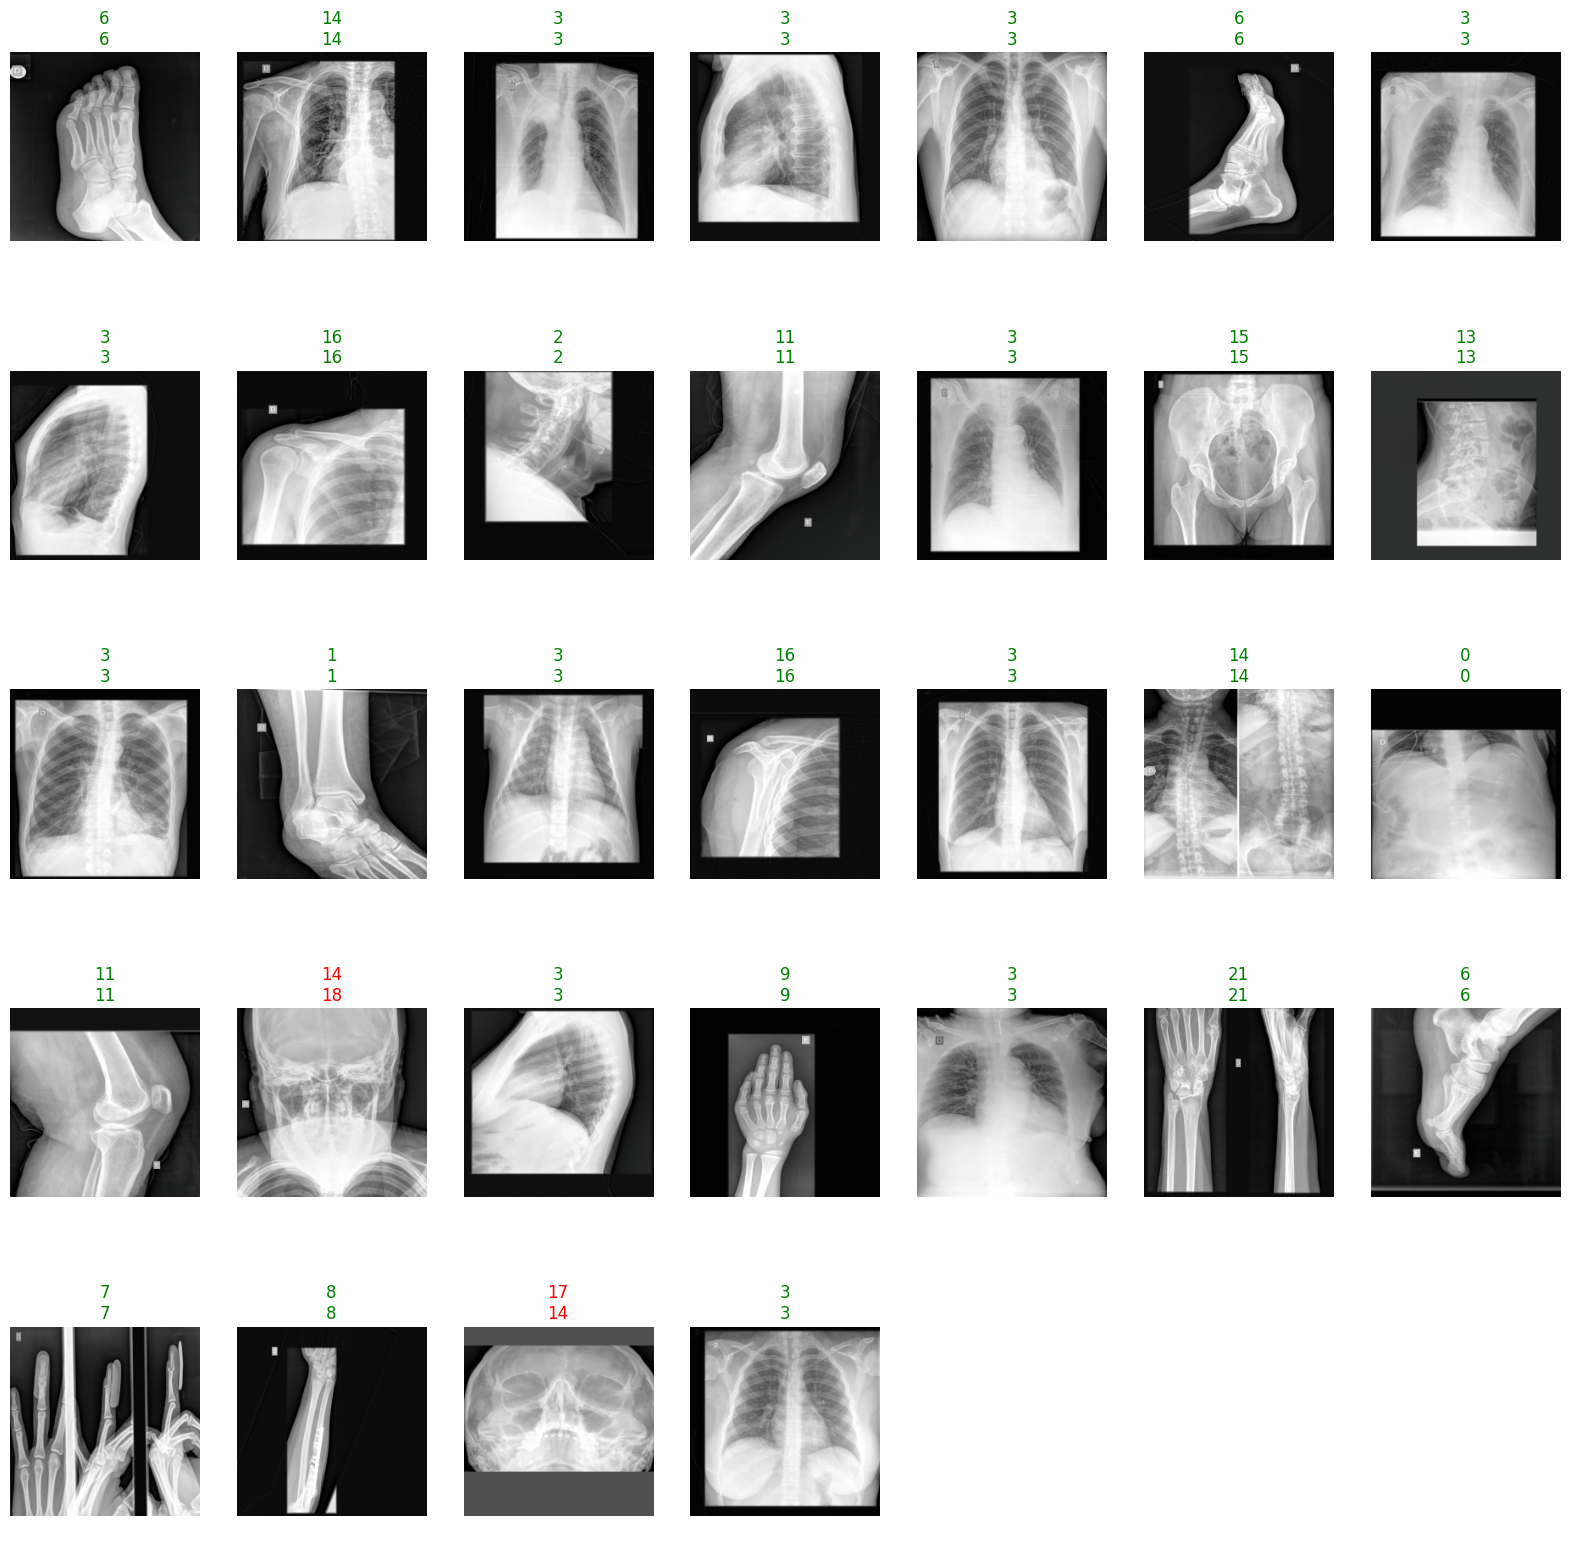

In [ ]:
from fastai.vision.all import load_learner

# Mostrar los resultados utilizando el modelo cargado
learn.show_results(max_n=50, figsize=(20, 20))

### Analisis de imagenes del sample_sumission y aplicacion de predicciones

Procesamiento de imagenes de test

In [ ]:
"""
import re

def preprocess_and_save_test_images(test_df, test_dir, zip_path, target_size=(224, 224)):
    X_test = []

    # Crear una barra de progreso acumulativo
    pbar = tqdm(total=len(test_df), desc="Procesando imágenes de test")

    for idx, row in test_df.iterrows():
        img_path = os.path.join(test_dir, row['SOPInstanceUID'] + '.dcm')
        img = preprocess_and_load_image(img_path, target_size=target_size)
        X_test.append(img)
        pbar.update(1)

    pbar.close()

    save_images_to_zip(X_test, zip_path)
    print("Proceso de guardado de imágenes completado correctamente.")

def save_images_to_zip(X, zip_path):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for idx, img in tqdm(enumerate(X), total=len(X), desc="Guardando imágenes"):
            img_filename = f'image_{idx}.png'

            # Convertir la imagen a formato adecuado para guardar con PIL
            if img.shape[2] == 3:  # RGB
                pil_img = Image.fromarray(img, mode='RGB')
            elif img.shape[2] == 1:  # Grayscale
                pil_img = Image.fromarray(img[:, :, 0], mode='L')  # 'L' mode is for (8-bit pixels, black and white)

            with BytesIO() as buffer:
                pil_img.save(buffer, format="PNG")
                buffer.seek(0)
                zipf.writestr(img_filename, buffer.read())


# Especificar la cantidad de imágenes a procesar y el tamaño de imagen deseado
num_images_to_process = len(train_df)  # Puedes ajustar esto según tus necesidades
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_test_5.zip'

# Cargar el DataFrame de test
test_df_1 = pd.read_csv(sample_submission_csv)
test_df = test_df_1.head(len(test_df_1))

# Procesar y guardar las imágenes de test en un archivo zip
preprocess_and_save_test_images(test_df, test_dir, zip_path, target_size=(224, 224))

"""

Descomprimir imagenes y aplicar predicciones

In [ ]:
def extract_and_load_images(zip_path, img_size=(224, 224)):
    # Crear un directorio temporal para extraer las imágenes
    extract_dir = './temp_extracted_images'
    os.makedirs(extract_dir, exist_ok=True)

    # Extraer los archivos del zip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Obtener la lista de archivos extraídos y ordenarlos alfabéticamente
    extracted_files = os.listdir(extract_dir)
    extracted_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))  # Ordenar los archivos según el número en el nombre

    # Lista para almacenar las imágenes cargadas
    X = []

    # Cargar las imágenes seleccionadas
    for filename in extracted_files:
        img_path = os.path.join(extract_dir, filename)
        img = PILImage.create(img_path)
        img = img.resize(img_size)
        X.append(img)

    # Limpiar el directorio temporal
    for file in extracted_files:
        os.remove(os.path.join(extract_dir, file))
    os.rmdir(extract_dir)

    print("Proceso de extracción y carga de imágenes completado correctamente.")
    return X


def make_predictions(learner, X):
    predictions = []

    for img in tqdm(X, desc="Aplicando predicciones del modelo"):
        pred, _, _ = learner.predict(img)
        predictions.append(pred)

    return predictions

# Extraer y cargar las imágenes desde el archivo zip
zip_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/processed_images_test_5.zip'
X_test = extract_and_load_images(zip_path)

# Especificar la ruta completa del archivo del modelo
saved_model_path = '/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/Data_Projects/DP4/models/best_model_6.pth'

# Realizar predicciones
predictions = make_predictions(learn, X_test)


Proceso de extracción y carga de imágenes completado correctamente.


Aplicando predicciones del modelo:   0%|          | 0/328 [00:00<?, ?it/s]

Aplicando predicciones del modelo:   1%|          | 3/328 [00:00<00:13, 23.97it/s]

Aplicando predicciones del modelo:   2%|▏         | 6/328 [00:00<00:12, 26.19it/s]

Aplicando predicciones del modelo:   3%|▎         | 9/328 [00:00<00:12, 24.91it/s]

Aplicando predicciones del modelo:   4%|▎         | 12/328 [00:00<00:12, 25.11it/s]

Aplicando predicciones del modelo:   5%|▍         | 15/328 [00:00<00:12, 25.72it/s]

Aplicando predicciones del modelo:   5%|▌         | 18/328 [00:00<00:11, 25.95it/s]

Aplicando predicciones del modelo:   6%|▋         | 21/328 [00:00<00:11, 26.59it/s]

Aplicando predicciones del modelo:   7%|▋         | 24/328 [00:00<00:11, 27.22it/s]

Aplicando predicciones del modelo:   8%|▊         | 27/328 [00:01<00:11, 27.18it/s]

Aplicando predicciones del modelo:   9%|▉         | 30/328 [00:01<00:11, 26.94it/s]

Aplicando predicciones del modelo:  10%|█         | 33/328 [00:01<00:10, 27.32it/s]

Aplicando predicciones del modelo:  11%|█         | 36/328 [00:01<00:10, 27.23it/s]

Aplicando predicciones del modelo:  12%|█▏        | 39/328 [00:01<00:10, 27.20it/s]

Aplicando predicciones del modelo:  13%|█▎        | 42/328 [00:01<00:10, 27.08it/s]

Aplicando predicciones del modelo:  14%|█▎        | 45/328 [00:01<00:10, 27.15it/s]

Aplicando predicciones del modelo:  15%|█▍        | 48/328 [00:01<00:10, 27.47it/s]

Aplicando predicciones del modelo:  16%|█▌        | 51/328 [00:01<00:10, 27.23it/s]

Aplicando predicciones del modelo:  16%|█▋        | 54/328 [00:02<00:10, 27.30it/s]

Aplicando predicciones del modelo:  17%|█▋        | 57/328 [00:02<00:09, 27.82it/s]

Aplicando predicciones del modelo:  18%|█▊        | 60/328 [00:02<00:09, 27.10it/s]

Aplicando predicciones del modelo:  19%|█▉        | 63/328 [00:02<00:09, 26.92it/s]

Aplicando predicciones del modelo:  20%|██        | 66/328 [00:02<00:09, 27.25it/s]

Aplicando predicciones del modelo:  21%|██        | 69/328 [00:02<00:09, 27.30it/s]

Aplicando predicciones del modelo:  22%|██▏       | 72/328 [00:02<00:09, 27.66it/s]

Aplicando predicciones del modelo:  23%|██▎       | 75/328 [00:02<00:09, 27.46it/s]

Aplicando predicciones del modelo:  24%|██▍       | 78/328 [00:02<00:09, 26.98it/s]

Aplicando predicciones del modelo:  25%|██▍       | 81/328 [00:03<00:08, 27.68it/s]

Aplicando predicciones del modelo:  26%|██▌       | 84/328 [00:03<00:08, 28.03it/s]

Aplicando predicciones del modelo:  27%|██▋       | 87/328 [00:03<00:08, 27.91it/s]

Aplicando predicciones del modelo:  27%|██▋       | 90/328 [00:03<00:08, 28.02it/s]

Aplicando predicciones del modelo:  28%|██▊       | 93/328 [00:03<00:08, 27.03it/s]

Aplicando predicciones del modelo:  29%|██▉       | 96/328 [00:03<00:08, 26.76it/s]

Aplicando predicciones del modelo:  30%|███       | 99/328 [00:03<00:08, 27.13it/s]

Aplicando predicciones del modelo:  31%|███       | 102/328 [00:03<00:08, 26.87it/s]

Aplicando predicciones del modelo:  32%|███▏      | 105/328 [00:03<00:08, 27.39it/s]

Aplicando predicciones del modelo:  33%|███▎      | 108/328 [00:03<00:07, 27.56it/s]

Aplicando predicciones del modelo:  34%|███▍      | 111/328 [00:04<00:08, 26.65it/s]

Aplicando predicciones del modelo:  35%|███▍      | 114/328 [00:04<00:08, 26.10it/s]

Aplicando predicciones del modelo:  36%|███▌      | 117/328 [00:04<00:07, 26.54it/s]

Aplicando predicciones del modelo:  37%|███▋      | 120/328 [00:04<00:07, 26.20it/s]

Aplicando predicciones del modelo:  38%|███▊      | 123/328 [00:04<00:07, 26.45it/s]

Aplicando predicciones del modelo:  38%|███▊      | 126/328 [00:04<00:07, 26.32it/s]

Aplicando predicciones del modelo:  39%|███▉      | 129/328 [00:04<00:07, 25.90it/s]

Aplicando predicciones del modelo:  40%|████      | 132/328 [00:04<00:07, 26.30it/s]

Aplicando predicciones del modelo:  41%|████      | 135/328 [00:05<00:07, 26.02it/s]

Aplicando predicciones del modelo:  42%|████▏     | 138/328 [00:05<00:07, 25.66it/s]

Aplicando predicciones del modelo:  43%|████▎     | 141/328 [00:05<00:07, 25.76it/s]

Aplicando predicciones del modelo:  44%|████▍     | 144/328 [00:05<00:07, 25.01it/s]

Aplicando predicciones del modelo:  45%|████▍     | 147/328 [00:05<00:07, 25.25it/s]

Aplicando predicciones del modelo:  46%|████▌     | 150/328 [00:05<00:07, 25.42it/s]

Aplicando predicciones del modelo:  47%|████▋     | 153/328 [00:05<00:06, 25.91it/s]

Aplicando predicciones del modelo:  48%|████▊     | 156/328 [00:05<00:06, 26.07it/s]

Aplicando predicciones del modelo:  48%|████▊     | 159/328 [00:05<00:06, 26.62it/s]

Aplicando predicciones del modelo:  49%|████▉     | 162/328 [00:06<00:06, 26.81it/s]

Aplicando predicciones del modelo:  50%|█████     | 165/328 [00:06<00:05, 27.35it/s]

Aplicando predicciones del modelo:  51%|█████     | 168/328 [00:06<00:05, 27.00it/s]

Aplicando predicciones del modelo:  52%|█████▏    | 171/328 [00:06<00:05, 27.12it/s]

Aplicando predicciones del modelo:  53%|█████▎    | 174/328 [00:06<00:05, 26.70it/s]

Aplicando predicciones del modelo:  54%|█████▍    | 177/328 [00:06<00:05, 27.21it/s]

Aplicando predicciones del modelo:  55%|█████▍    | 180/328 [00:06<00:05, 27.52it/s]

Aplicando predicciones del modelo:  56%|█████▌    | 183/328 [00:06<00:05, 27.67it/s]

Aplicando predicciones del modelo:  57%|█████▋    | 186/328 [00:06<00:05, 27.73it/s]

Aplicando predicciones del modelo:  58%|█████▊    | 189/328 [00:07<00:05, 27.61it/s]

Aplicando predicciones del modelo:  59%|█████▊    | 192/328 [00:07<00:04, 27.54it/s]

Aplicando predicciones del modelo:  59%|█████▉    | 195/328 [00:07<00:04, 27.58it/s]

Aplicando predicciones del modelo:  60%|██████    | 198/328 [00:07<00:04, 27.65it/s]

Aplicando predicciones del modelo:  61%|██████▏   | 201/328 [00:07<00:04, 26.96it/s]

Aplicando predicciones del modelo:  62%|██████▏   | 204/328 [00:07<00:04, 26.59it/s]

Aplicando predicciones del modelo:  63%|██████▎   | 207/328 [00:07<00:04, 26.32it/s]

Aplicando predicciones del modelo:  64%|██████▍   | 210/328 [00:07<00:04, 26.17it/s]

Aplicando predicciones del modelo:  65%|██████▍   | 213/328 [00:07<00:04, 25.90it/s]

Aplicando predicciones del modelo:  66%|██████▌   | 216/328 [00:08<00:04, 25.91it/s]

Aplicando predicciones del modelo:  67%|██████▋   | 219/328 [00:08<00:04, 26.23it/s]

Aplicando predicciones del modelo:  68%|██████▊   | 222/328 [00:08<00:04, 26.12it/s]

Aplicando predicciones del modelo:  69%|██████▊   | 225/328 [00:08<00:04, 25.45it/s]

Aplicando predicciones del modelo:  70%|██████▉   | 228/328 [00:08<00:04, 24.15it/s]

Aplicando predicciones del modelo:  70%|███████   | 231/328 [00:08<00:03, 24.43it/s]

Aplicando predicciones del modelo:  71%|███████▏  | 234/328 [00:08<00:03, 24.89it/s]

Aplicando predicciones del modelo:  72%|███████▏  | 237/328 [00:08<00:03, 25.31it/s]

Aplicando predicciones del modelo:  73%|███████▎  | 240/328 [00:09<00:03, 25.66it/s]

Aplicando predicciones del modelo:  74%|███████▍  | 243/328 [00:09<00:03, 25.74it/s]

Aplicando predicciones del modelo:  75%|███████▌  | 246/328 [00:09<00:03, 25.52it/s]

Aplicando predicciones del modelo:  76%|███████▌  | 249/328 [00:09<00:03, 25.70it/s]

Aplicando predicciones del modelo:  77%|███████▋  | 252/328 [00:09<00:02, 25.66it/s]

Aplicando predicciones del modelo:  78%|███████▊  | 255/328 [00:09<00:02, 25.67it/s]

Aplicando predicciones del modelo:  79%|███████▊  | 258/328 [00:09<00:02, 25.55it/s]

Aplicando predicciones del modelo:  80%|███████▉  | 261/328 [00:09<00:02, 24.23it/s]

Aplicando predicciones del modelo:  80%|████████  | 264/328 [00:09<00:02, 24.90it/s]

Aplicando predicciones del modelo:  81%|████████▏ | 267/328 [00:10<00:02, 25.34it/s]

Aplicando predicciones del modelo:  82%|████████▏ | 270/328 [00:10<00:02, 25.46it/s]

Aplicando predicciones del modelo:  83%|████████▎ | 273/328 [00:10<00:02, 26.15it/s]

Aplicando predicciones del modelo:  84%|████████▍ | 276/328 [00:10<00:01, 26.32it/s]

Aplicando predicciones del modelo:  85%|████████▌ | 279/328 [00:10<00:01, 26.01it/s]

Aplicando predicciones del modelo:  86%|████████▌ | 282/328 [00:10<00:01, 25.90it/s]

Aplicando predicciones del modelo:  87%|████████▋ | 285/328 [00:10<00:01, 25.66it/s]

Aplicando predicciones del modelo:  88%|████████▊ | 288/328 [00:10<00:01, 25.85it/s]

Aplicando predicciones del modelo:  89%|████████▊ | 291/328 [00:11<00:01, 26.01it/s]

Aplicando predicciones del modelo:  90%|████████▉ | 294/328 [00:11<00:01, 26.17it/s]

Aplicando predicciones del modelo:  91%|█████████ | 297/328 [00:11<00:01, 26.93it/s]

Aplicando predicciones del modelo:  91%|█████████▏| 300/328 [00:11<00:01, 27.03it/s]

Aplicando predicciones del modelo:  92%|█████████▏| 303/328 [00:11<00:00, 27.06it/s]

Aplicando predicciones del modelo:  93%|█████████▎| 306/328 [00:11<00:00, 27.10it/s]

Aplicando predicciones del modelo:  94%|█████████▍| 309/328 [00:11<00:00, 27.08it/s]

Aplicando predicciones del modelo:  95%|█████████▌| 312/328 [00:11<00:00, 27.00it/s]

Aplicando predicciones del modelo:  96%|█████████▌| 315/328 [00:11<00:00, 27.08it/s]

Aplicando predicciones del modelo:  97%|█████████▋| 318/328 [00:12<00:00, 26.83it/s]

Aplicando predicciones del modelo:  98%|█████████▊| 321/328 [00:12<00:00, 26.72it/s]

Aplicando predicciones del modelo:  99%|█████████▉| 324/328 [00:12<00:00, 26.53it/s]

Aplicando predicciones del modelo: 100%|█████████▉| 327/328 [00:12<00:00, 26.81it/s]

Aplicando predicciones del modelo: 100%|██████████| 328/328 [00:12<00:00, 26.49it/s]


# Creacion del sample_sumission.csv e imputacion de predicciones

Creacion y guardado del csv

In [ ]:
# preparacion del df
test_df = pd.read_csv(sample_submission_csv)
submission_df = test_df.copy()
submission_df['Target'] = predictions
submission_df.to_csv('/content/drive/Othercomputers/Mi Portátil/Dropbox/Facu/EDEM/GitHub/GitHub_Repositorios/dp4_team2/cris/sample_submission_cris_10csv', index=False)
submission_df


SOPInstanceUID Target
0    1.2.826.0.1.3680043.8.498.75932240489221075589097397484896361550      3
1    1.2.826.0.1.3680043.8.498.80518330963406833915089209886834390159     11
2    1.2.826.0.1.3680043.8.498.97413731471864060627365739417678218380     11
3    1.2.826.0.1.3680043.8.498.98229201581139590153090960568103270985      2
4    1.2.826.0.1.3680043.8.498.84551354213532970228348448377009898172      3
..                                                                ...    ...
323  1.2.826.0.1.3680043.8.498.60964782211363234805993194732570333546      5
324  1.2.826.0.1.3680043.8.498.90617059056548212763113895515703343197     16
325  1.2.826.0.1.3680043.8.498.77795747668217965858748681496943891312      3
326  1.2.826.0.1.3680043.8.498.83898837859028979514441043450695737481      1
327  1.2.826.0.1.3680043.8.498.76482195481290376937939274201235029927     14

[328 rows x 2 columns]

Distribucion de predicciones

In [ ]:
#Distribucion de predicciones
submission_df['Target'] = pd.to_numeric(submission_df['Target'], errors='coerce')
grouped = submission_df.groupby('Target').size().reset_index(name='Frecuencia')


# Diccionario que mapea los números de la columna 'Target' con los nombres de partes del cuerpo
id = {
    0: 'Abdomen',
    1: 'Tobillo',
    2: 'Columna cervical',
    3: 'Tórax',
    4: 'Clavículas',
    5: 'Codo',
    6: 'Pies',
    7: 'Dedos',
    8: 'Antebrazo',
    9: 'Mano',
    10: 'Cadera',
    11: 'Rodilla',
    12: 'Pierna',
    13: 'Columna lumbar',
    14: 'Otros',
    15: 'Pelvis',
    16: 'Hombro',
    17: 'Senos paranasales',
    18: 'Cráneo',
    19: 'Muslo',
    20: 'Columna torácica',
    21: 'Muñeca'
}

# Nuevas columnas y agrupaciones
grouped['Seccion'] = grouped['Target'].map(id)
grouped_sorted = grouped.sort_values(by='Frecuencia', ascending=False)
total = grouped_sorted['Frecuencia'].sum()
grouped_sorted['%'] = (grouped_sorted['Frecuencia'] / total) * 100


grouped_sorted


Target  Frecuencia            Seccion          %
3        3         150              Tórax  45.731707
14      15          26             Pelvis   7.926829
13      14          24              Otros   7.317073
10      11          19            Rodilla   5.792683
2        2          16   Columna cervical   4.878049
1        1          14            Tobillo   4.268293
19      21          14             Muñeca   4.268293
6        6          14               Pies   4.268293
0        0           9            Abdomen   2.743902
15      16           9             Hombro   2.743902
8        9           8               Mano   2.439024
12      13           6     Columna lumbar   1.829268
5        5           5               Codo   1.524390
16      17           3  Senos paranasales   0.914634
17      18           3             Cráneo   0.914634
11      12           3             Pierna   0.914634
4        4           2         Clavículas   0.609756
7        7           1              Dedos   0.304878
9       10           1             Cadera   0.304878
18      20           1   Columna torácica   0.304878

Visualizacion de imagenes TEST y targets

In [ ]:
def visualize_predictions_with_names(X, predictions, num_images_to_show=150, grid_size=(30, 5)):
    num_images = min(num_images_to_show, len(X))
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(4 * grid_size[1], 4 * grid_size[0]))

    for i in range(num_images):
        row = i // grid_size[1]
        col = i % grid_size[1]
        axs[row, col].imshow(X[i])
        axs[row, col].axis('off')

        # Obtener el nombre de la predicción
        pred_name = id[int(predictions[i])]

        axs[row, col].set_title(f'{pred_name}')

    # Ocultar los ejes de los subplots no utilizados
    for j in range(num_images, grid_size[0] * grid_size[1]):
        row = j // grid_size[1]
        col = j % grid_size[1]
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualizar las imágenes con sus predicciones
visualize_predictions_with_names(X_test, predictions, num_images_to_show=150, grid_size=(30, 5))



Output hidden; open in https://colab.research.google.com to view.